[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/williamyang1991/GP-UNIT/blob/master/notebooks/inference_playground.ipynb)

code is mainly modified from [pixel2style2pixel](https://github.com/eladrich/pixel2style2pixel/blob/master/notebooks/inference_playground.ipynb)

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
os.chdir('../')
CODE_DIR = 'GPUNIT'

In [ ]:
!git clone https://github.com/williamyang1991/GP-UNIT.git $CODE_DIR

!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force 

In [ ]:
#os.chdir(f'./{CODE_DIR}')
MODEL_DIR = os.path.join(os.path.dirname(os.getcwd()), CODE_DIR, 'checkpoint')
DATA_DIR = os.path.join(os.path.dirname(os.getcwd()), CODE_DIR, 'data')

In [ ]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append(".")
sys.path.append("..")

import numpy as np
import torch
from util import save_image, load_image, visualize
from torchvision import transforms
from torch.nn import functional as F
import torchvision
import matplotlib.pyplot as plt
from model.generator import Generator
from model.content_encoder import ContentEncoder
from model.sampler import ICPTrainer

## Step 1: Select Style Type

In [ ]:
tasks = ['female2male', 'male2female', 'cat2dog', 'dog2cat', 'face2cat', 'cat2face', 'bird2dog', 'dog2bird', 'bird2car', 'car2bird']
task = tasks[2]

## Step 2: Download Pretrained Models 
As part of this repository, we provide pretrained models. We'll download the model and save them to the folder `../checkpoint/`.

In [ ]:
def get_download_model_command(file_id, file_name):
    """ Get wget download command for downloading the desired model and save to directory ../checkpoint/. """
    current_directory = os.getcwd()
    save_path = MODEL_DIR
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    url = r"""wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id={FILE_ID}' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id={FILE_ID}" -O {SAVE_PATH}/{FILE_NAME} && rm -rf /tmp/cookies.txt""".format(FILE_ID=file_id, FILE_NAME=file_name, SAVE_PATH=save_path)
    return url

In [ ]:
MODEL_PATHS = {
    "encoder": {"id": "1I7_IMMheihcIR57vInof5g6R0j8wEonx", "name": "content_encoder.pt"},
    "female2male": {"id": "19xIY0vqHVpah4UyXKgz7trWi1TdlPD_T", "name": "female2male.pt"},
    "male2female": {"id": "1I0xqtbuuPOhcteHH613PGX7uO3fMTf9r", "name": "male2female.pt"},    
    "cat2dog": {"id": "1EvQRKY4AN1JxAElsOPkuqqSRZVCNL3gA", "name": "cat2dog.pt"},
    "dog2cat": {"id": "1PJyk0hKClceTHRD6BORFVEpG-pl0lPFm", "name": "dog2cat.pt"},
    "face2cat": {"id": "1CKKXDaD0h6i1RFtbcHOL8Bj3P37_Cheh", "name": "face2cat.pt"},
    "cat2face": {"id": "1cAYIYU6JUunBRhw94cssp8cPnuD7hJgo", "name": "cat2face.pt"},
    "bird2dog": {"id": "1Nm0jAI6dxDLBUdIFPEx8qU002IUdBaTO", "name": "bird2dog.pt"},
    "dog2bird": {"id": "1Ud_IJTO8Ovi7T7lsMG3S9boYASemnVAB", "name": "dog2bird.pt"},
    "bird2car": {"id": "1PR_AF8JnYMaXH3hKipGxUZEjgrUu_0r5", "name": "bird2car.pt"},
    "car2bird": {"id": "1j1N6vMNhPt4beLDrwP-uBd-jgPoQqg4O", "name": "car2bird.pt"},
}

In [ ]:
# download content encoder
path = MODEL_PATHS["encoder"]
download_command = get_download_model_command(file_id=path["id"], file_name=path["name"])
!{download_command}

In [ ]:
# download translation network
path = MODEL_PATHS[task]
download_command = get_download_model_command(file_id=path["id"], file_name=path["name"])
!{download_command}

## Step 3: Load Pretrained Model
We assume that you have downloaded all relevant models and placed them in the directory defined by the above dictionary.

In [ ]:
task = tasks[8]

In [ ]:
device = 'cuda'

In [ ]:
netEC = ContentEncoder()
netEC.eval()
netG = Generator()
netG.eval()
sampler = ICPTrainer(np.empty([0,256]), 128)

netEC.load_state_dict(torch.load(os.path.join(MODEL_DIR, MODEL_PATHS["encoder"]["name"]), map_location=lambda storage, loc: storage))
ckpt = torch.load(os.path.join(MODEL_DIR, MODEL_PATHS[task]["name"]), map_location=lambda storage, loc: storage)
netG.load_state_dict(ckpt['g_ema'])
sampler.icp.netT.load_state_dict(ckpt['sampler'])

netEC = netEC.to(device)
netG = netG.to(device)
sampler.icp.netT = sampler.icp.netT.to(device)

print('Model successfully loaded!')

Model successfully loaded!


## Step 5: Visualize Input

In [ ]:
%matplotlib inline

In [ ]:
EXPERIMENT_DATA_ARGS = {
    "female2male": {
        "content_path": "./data/celeba_hq/val/female/002569.jpg",
        "style_path": "./data/celeba_hq/val/male/020167.jpg"
    },
    "male2female": {
        "content_path": "./data/celeba_hq/val/male/020167.jpg",
        "style_path": "./data/celeba_hq/val/female/002569.jpg"
    },
    "cat2dog": {
        "content_path": "./data/afhq/images512x512/test/cat/flickr_cat_000418.jpg",
        "style_path": "./data/afhq/images512x512/test/dog/flickr_dog_000572.jpg"
    },
    "dog2cat": {
        "content_path": "./data/afhq/images512x512/test/dog/flickr_dog_000572.jpg",
        "style_path": "./data/afhq/images512x512/test/cat/flickr_cat_000418.jpg"
    },
    "face2cat": {
        "content_path": "./data/ImageNet291/test/1001_face/29057.jpg",
        "style_path": "./data/afhq/images512x512/test/cat/pixabay_cat_000441.jpg"
    },
    "cat2face": {
        "content_path": "./data/afhq/images512x512/test/cat/pixabay_cat_000441.jpg",
        "style_path": "./data/ImageNet291/test/1001_face/29057.jpg"
    },   
    "bird2dog": {
        "content_path": "./data/ImageNet291/test/11_bird/370.jpg",
        "style_path": "./data/ImageNet291/test/232_dog/260.jpg"
    },
    "dog2bird": {
        "content_path": "./data/ImageNet291/test/232_dog/260.jpg",
        "style_path": "./data/ImageNet291/test/11_bird/370.jpg"
    },  
    "bird2car": {
        "content_path": "./data/ImageNet291/test/11_bird/370.jpg",
        "style_path": "./data/ImageNet291/test/627_vehicle/320.jpg"
    },
    "car2bird": {
        "content_path": "./data/ImageNet291/test/627_vehicle/320.jpg",
        "style_path": "./data/ImageNet291/test/11_bird/370.jpg"
    },  
}

In [ ]:
Ix = F.interpolate(load_image(EXPERIMENT_DATA_ARGS[task]["content_path"]), size=256, mode='bilinear', align_corners=True)
Iy = F.interpolate(load_image(EXPERIMENT_DATA_ARGS[task]["style_path"]), size=256, mode='bilinear', align_corners=True)

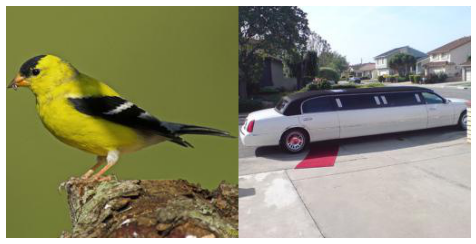

In [ ]:
plt.figure(figsize=(10,10),dpi=60)
visualize(torch.cat((Ix, Iy), dim=3)[0])
plt.show()

## Step 6: Perform Inference -- Latent-Guided Translation

In [ ]:
seed = 233
torch.manual_seed(seed)
batch = 9 # sample 6 style codes
with torch.no_grad():
    content_feature = netEC(Ix.to(device), get_feature=True)
    style_features = sampler.icp.netT(torch.randn(batch,128).to(device)) 
    I_yhats, _ = netG(content_feature, style_features, useZ=True)

### Visualize Results
From left to right, top to bottom:
1. **Input content image**
2. **Nine translation results with random styles**

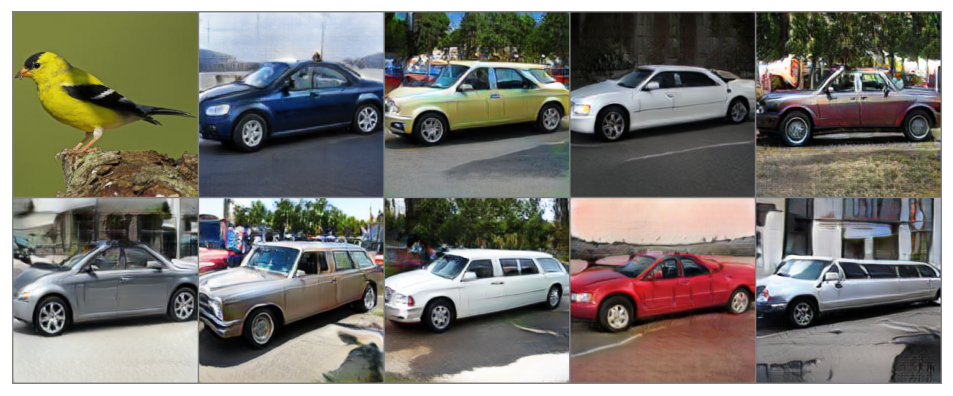

In [ ]:
viz = torchvision.utils.make_grid(torch.cat([Ix, I_yhats.cpu()], dim=0), (batch+1)//2, 2)
plt.figure(figsize=(10,10),dpi=120)
visualize(viz)
plt.show()

### Navigation with different interpolated styles

In [ ]:
interstyles = []

for i in range(7):
    for j in range(7):
        ii = i // 3
        jj = j // 3
        ii1 = min(ii + 1, 2)
        jj1 = min(jj + 1, 2)
        offi = i - ii * 3
        offj = j - jj * 3
        tmp = (style_features[ii*3+jj]*(3-offi)*(3-offj) + style_features[ii*3+jj1]*(3-offi)*offj 
               + style_features[ii1*3+jj]*offi*(3-offj) + style_features[ii1*3+jj1]*offi*offj)
        interstyles += [tmp.unsqueeze_(dim=0)/9.0]
        
interp_style_features = torch.cat(interstyles, dim=0)

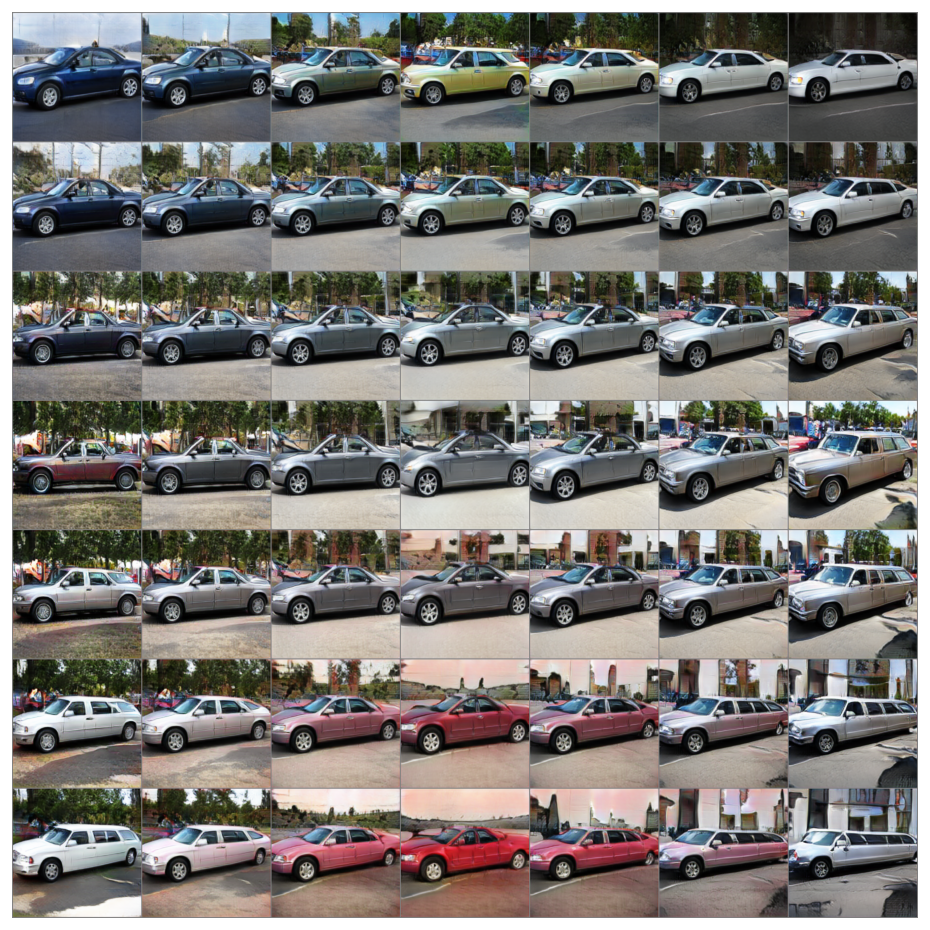

In [ ]:
with torch.no_grad():
    I_yhats, _ = netG(content_feature, interp_style_features, useZ=True)

viz = torchvision.utils.make_grid(I_yhats.cpu(), 7, 2)
plt.figure(figsize=(10,10),dpi=120)
visualize(viz)
plt.show()

## Step 7: Perform Inference -- Exemplar-Guided Translation

In [ ]:
with torch.no_grad():
    I_yhat, _ = netG(content_feature, Iy.to(device))

### Visualize Results
From left to right:
1. **Input content image**
2. **Input style image**
2. **Translation result**

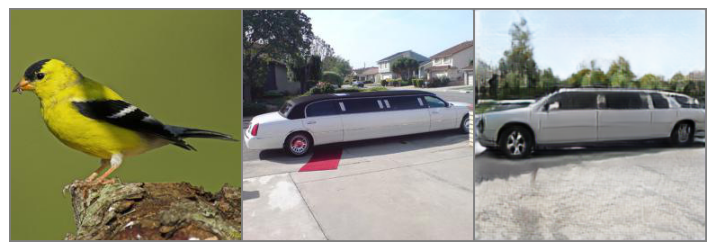

In [ ]:
viz = torchvision.utils.make_grid(torch.cat([Ix, Iy, I_yhat.cpu()], dim=0), 3, 2)
plt.figure(figsize=(10,10),dpi=90)
visualize(viz)
plt.show()